# Inclusion financière en Afrique

## 0. Préalable

### Importation des modules

In [2]:
# numerical calculation
import numpy as np
# dataframe
import pandas as pd
# vizualisation
import matplotlib.pyplot as plt
import seaborn as sns
# models
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
# splitting
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.utils import resample
# encoding
from sklearn.preprocessing import OrdinalEncoder
# scaling
from sklearn.preprocessing import MinMaxScaler
# metrics
from sklearn.metrics import mean_absolute_error, ConfusionMatrixDisplay
# utils
import random
from datetime import datetime as dt
# saving model
import joblib

In [3]:
# Set seed for reproducability
SEED = 12
random.seed(SEED)
np.random.seed(SEED)

### Chargement du jeu de données

In [4]:
DATA_PATH = 'data/' # repertoire des données
train_set = pd.read_csv(DATA_PATH + 'Train.csv') # ensemble d'apprentissage
test_set = pd.read_csv(DATA_PATH + 'Test.csv') # ensemble de test
sample_submission = pd.read_csv(DATA_PATH + 'SampleSubmission.csv') # exemple de soumission

In [5]:
train_set.head(4)

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private


In [6]:
ID = 'uniqueid'
TARGET = 'bank_account'

## 1. Analyse exploratoire

### 1.1. Analyse de la forme

La target de notre dataset est la variable **bank_account**.

Dimension du dataset

In [7]:
# Let’s observe the shape of our datasets.
print('Dimension du train set :', train_set.shape)
print('Dimension du test set :', test_set.shape)

Dimension du train set : (23524, 13)
Dimension du test set : (10086, 12)


Types des variables

In [8]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23524 entries, 0 to 23523
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   country                 23524 non-null  object
 1   year                    23524 non-null  int64 
 2   uniqueid                23524 non-null  object
 3   bank_account            23524 non-null  object
 4   location_type           23524 non-null  object
 5   cellphone_access        23524 non-null  object
 6   household_size          23524 non-null  int64 
 7   age_of_respondent       23524 non-null  int64 
 8   gender_of_respondent    23524 non-null  object
 9   relationship_with_head  23524 non-null  object
 10  marital_status          23524 non-null  object
 11  education_level         23524 non-null  object
 12  job_type                23524 non-null  object
dtypes: int64(3), object(10)
memory usage: 2.3+ MB


Analyse des variables qualitatives

In [9]:
train_set.describe(include='object')

,country,uniqueid,bank_account,location_type,cellphone_access,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
count,23524,23524,23524,23524,23524,23524,23524,23524,23524,23524
unique,4,8735,2,2,2,2,6,5,6,10
top,Rwanda,uniqueid_1,No,Rural,Yes,Female,Head of Household,Married/Living together,Primary education,Self employed
freq,8735,4,20212,14343,17454,13877,12831,10749,12791,6437


In [11]:
for colonne in list(train_set.columns):
    print(train_set[colonne].value_counts(), '\n')

country
Rwanda      8735
Tanzania    6620
Kenya       6068
Uganda      2101
Name: count, dtype: int64 

year
2016    8735
2018    8169
2017    6620
Name: count, dtype: int64 

uniqueid
uniqueid_1       4
uniqueid_1413    4
uniqueid_1411    4
uniqueid_1410    4
uniqueid_1409    4
                ..
uniqueid_7318    1
uniqueid_7317    1
uniqueid_7316    1
uniqueid_7315    1
uniqueid_8759    1
Name: count, Length: 8735, dtype: int64 

bank_account
No     20212
Yes     3312
Name: count, dtype: int64 

location_type
Rural    14343
Urban     9181
Name: count, dtype: int64 

cellphone_access
Yes    17454
No      6070
Name: count, dtype: int64 

household_size
2     5229
3     3920
4     3474
1     3057
5     2853
6     2096
7     1400
8      751
9      363
10     190
11      69
12      68
13      25
15      11
14      10
16       4
21       1
18       1
17       1
20       1
Name: count, dtype: int64 

age_of_respondent
30     1056
35      836
25      792
28      748
32      715
       ... 
1

Analyse des variables quantitatives

In [12]:
train_set.describe(include='number')

,year,household_size,age_of_respondent
count,23524.000000,23524.000000,23524.000000
mean,2016.975939,3.797483,38.805220
std,0.847371,2.227613,16.520569
min,2016.000000,1.000000,16.000000
25%,2016.000000,2.000000,26.000000
50%,2017.000000,3.000000,35.000000
75%,2018.000000,5.000000,49.000000
max,2018.000000,21.000000,100.000000


Analyse des données manquantes

In [13]:
train_set.isnull().sum()

country                   0
year                      0
uniqueid                  0
bank_account              0
location_type             0
cellphone_access          0
household_size            0
age_of_respondent         0
gender_of_respondent      0
relationship_with_head    0
marital_status            0
education_level           0
job_type                  0
dtype: int64

Super ! Notre dataset ne contient aucune donnée manquante.

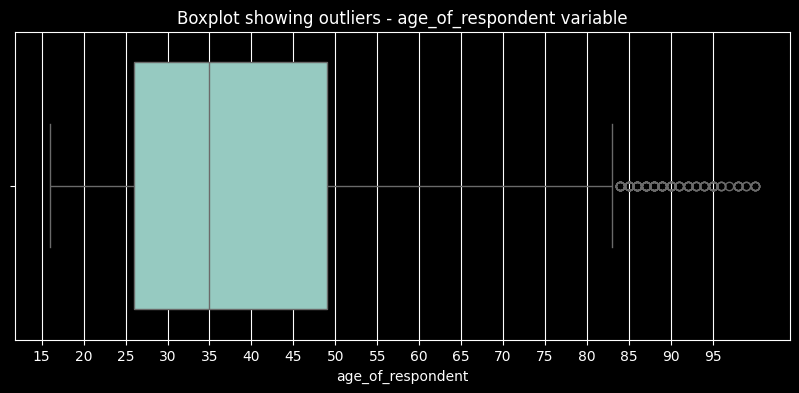

In [14]:
# Check for outliers in the target variable
plt.figure(figsize=(10, 4))
plt.grid()
plt.xticks(np.arange(0, 100, 5))
sns.boxplot(x=train_set['age_of_respondent'])
plt.title('Boxplot showing outliers - age_of_respondent variable')
plt.show()

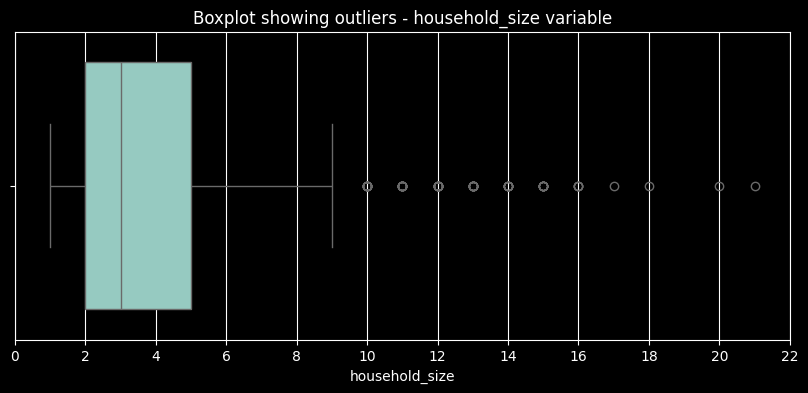

In [15]:
plt.figure(figsize=(10, 4))
plt.grid()
plt.xticks(np.arange(0, 30, 2))
sns.boxplot(x=train_set['household_size'])
plt.title('Boxplot showing outliers - household_size variable')
plt.show()

Il n'y a aucun outlier dans ce dataset.

### 1.2. Analyse du fond

Analyse et visualisation de la target (bank_account)

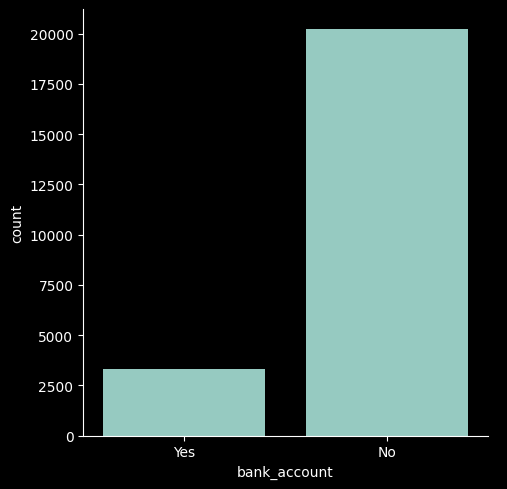

In [16]:
# explorons la distribution de la target
sns.catplot(data=train_set, x=TARGET, kind='count')
plt.show()

Matrice de corrélation de toutes les variables

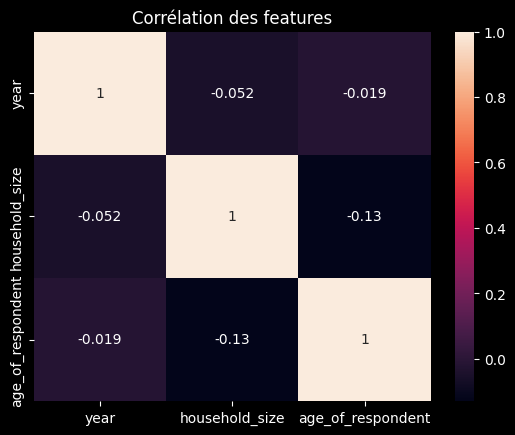

In [17]:
plt.title('Corrélation des features')
sns.heatmap(train_set.corr(numeric_only=True), annot=True)
plt.show()

00 corrélation entre les variables du dataset

## 2. Pré-traitement

In [19]:
# Instantiating the scalers
MMS = MinMaxScaler()

### 2.1. Fonction réalisant le pré-traitement de notre dataset

#### Augmentation d'enregistrements

In [18]:
train_set.shape

(23524, 13)

In [20]:
data_majority = train_set[train_set[TARGET] == 'No']
data_minority = train_set[train_set[TARGET] == 'Yes']

data_minority_oversampled = resample(data_minority, 
                                    replace=True, 
                                    n_samples=len(data_majority) // 5, 
                                    random_state=SEED)

train_balanced = pd.concat([data_majority, data_minority_oversampled])
train_balanced.shape

(24254, 13)

In [21]:
data_majority.shape

(20212, 13)

In [22]:
data_minority_oversampled.shape

(4042, 13)

#### Augmentation de variables

In [23]:
def is_employed(job):
    ''' 
    '''
    if job in ['Dont Know/Refuse to answer', 'Other Income']:
        return 'Other'
    elif job in ['Remittance Dependent', 'Government Dependent', 'Farming and Fishing', 'No Income']:
        return 'No'
    else:
        return 'Yes'


def has_been_married(status):
    ''' 
    '''
    if status in ['Dont know']:
        return 'Other'
    elif status in ['Single/Never Married']:
        return 'No'
    else:
        return 'Yes'


def id_educated(level):
    ''' 
    '''
    if level in ['Other/Dont know/RTA']:
        return 'Other'
    elif level in ['Vocational/Specialised training', 'No formal education']:
        return 'No'
    else:
        return 'Yes'


def id_head(relationship):
    ''' 
    '''
    if relationship in ['Head of Household']:
        return 'Yes'
    else:
        return 'No'

In [24]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    ''' 
    '''
    data1 = data.copy()
    data1['age_category'] = data1['age_of_respondent'].apply(
        lambda x: str(x) if x < 84 else 'Vieux')
    data1['household_category'] = data1['household_size'].apply(
        lambda x: str(x) if x < 10 else 'Grand')
    data1['has_been_married'] = data1['marital_status'].apply(
        has_been_married)
    data1['id_educated'] = data1['education_level'].apply(
        id_educated)
    data1['is_employed'] = data1['job_type'].apply(is_employed)
    data1['id_head'] = data1['relationship_with_head'].apply(
        id_head)
    # la liste des colonnes discrètes
    object_columns = list(
        data1.select_dtypes(include='object').columns)
    # encodage des variables discrètes
    encoder = OrdinalEncoder()
    data1[object_columns] = encoder.fit_transform(
        data1[object_columns])
    # normalisation
    scaler = MMS
    data1[data1.columns] = scaler.fit_transform(data1)
    return data1

In [25]:
train_featured = feature_engineering(train_set)
test_featured = feature_engineering(test_set)
test_featured.drop(TARGET, axis=1, inplace=True)
test_featured.head()

KeyError: "['bank_account'] not found in axis"

#### Dummification

In [26]:
def processing_dummy(data: pd.DataFrame) -> pd.DataFrame:
    ''' preprocessing d'un dataframe avec la méthode de dummification
    '''
    try:
        data_dummy = pd.get_dummies(
            data.drop([ID, TARGET], axis=1))
        # normalisation
        scaler = MMS
        data_dummy[data_dummy.columns] = scaler.fit_transform(data_dummy)
        data_dummy[TARGET] = data[TARGET]
    except:
        data_dummy = pd.get_dummies(data.drop([ID], axis=1))
        # normalisation
        scaler = MMS
        data_dummy[data_dummy.columns] = scaler.fit_transform(data_dummy)
    try:
        # la liste des colonnes discrètes
        object_columns = list(
            data_dummy.select_dtypes(include='object').columns)
        # encodage des variables discrètes
        encoder = OrdinalEncoder()
        data_dummy[object_columns] = encoder.fit_transform(
            data_dummy[object_columns])
    except:
        pass
    return data_dummy

In [27]:
train_dummy = processing_dummy(train_set)
test_dummy = processing_dummy(test_set)
test_dummy.head()

,year,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,location_type_Urban,cellphone_access_No,...,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,1.0,0.105263,0.166667,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.315789,0.416667,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.105263,0.726190,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.263158,0.273810,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.105263,0.000000,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 2.2. Splitting pour l'entrainement

In [28]:
X_train_dummy = train_dummy.drop([TARGET], axis=1)
y_train_dummy = train_dummy[TARGET]
X_train_dummy.head()

,year,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,location_type_Urban,cellphone_access_No,...,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,1.0,0.10,0.095238,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.20,0.642857,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.20,0.119048,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.20,0.214286,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.35,0.119048,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [29]:
X_train_featured = train_featured.drop([TARGET], axis=1)
y_train_featured = train_featured[TARGET]
X_train_featured.head()

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,age_category,household_category,has_been_married,id_educated,is_employed,id_head
0,0.0,1.0,0.000000,0.0,1.0,0.10,0.095238,0.0,1.0,0.50,0.6,1.000000,0.117647,0.222222,1.0,1.0,1.0,0.0
1,0.0,1.0,0.127204,0.0,0.0,0.20,0.642857,0.0,0.2,1.00,0.0,0.444444,0.794118,0.444444,1.0,0.0,0.0,1.0
2,0.0,1.0,0.254408,1.0,1.0,0.20,0.119048,1.0,0.6,0.75,1.0,1.000000,0.147059,0.444444,0.0,0.0,1.0,0.0
3,0.0,1.0,0.381612,0.0,1.0,0.20,0.214286,0.0,0.2,0.50,0.4,0.333333,0.264706,0.444444,1.0,1.0,1.0,1.0
4,0.0,1.0,0.508816,1.0,0.0,0.35,0.119048,1.0,0.0,0.75,0.4,0.555556,0.147059,0.777778,0.0,1.0,1.0,0.0


Séparation des features et de la target

In [30]:
X_Train_dummy, X_Val_dummy, y_Train_dummy, y_Val_dummy = train_test_split(X_train_dummy, y_train_dummy, test_size = 0.1, random_state=SEED)

In [31]:
X_Train_featured, X_Val_featured, y_Train_featured, y_Val_featured = train_test_split(X_train_featured, y_train_featured, test_size = 0.1, random_state=SEED)

## 3. Modélisation

### 3.1. Entrainement et score

In [32]:
params = {
    'n_estimators': 3000,
    'learning_rate': 0.1,
    'objective': 'Logloss',
    'rsm': 0.7,
    'random_seed': SEED,
    'early_stopping_rounds': 200,
    'use_best_model': True,
}

model_dummy = CatBoostClassifier(**params)
model_dummy.fit(X_Train_dummy, y_Train_dummy, eval_set=[
                (X_Val_dummy, y_Val_dummy)], verbose=50)

y_model_dummy = model_dummy.predict(X_Val_dummy)
metrique = mean_absolute_error(y_Val_dummy, y_model_dummy)
print(f"Taux d'erreur du {str(model_dummy)} : {metrique}")

0:	learn: 0.6007609	test: 0.6000447	best: 0.6000447 (0)	total: 208ms	remaining: 10m 23s
50:	learn: 0.2743848	test: 0.2612727	best: 0.2612727 (50)	total: 1.2s	remaining: 1m 9s
100:	learn: 0.2647134	test: 0.2582489	best: 0.2582489 (100)	total: 2.12s	remaining: 1m
150:	learn: 0.2566342	test: 0.2584554	best: 0.2580459 (140)	total: 2.93s	remaining: 55.3s
200:	learn: 0.2500581	test: 0.2609648	best: 0.2580459 (140)	total: 3.75s	remaining: 52.2s
250:	learn: 0.2442592	test: 0.2625673	best: 0.2580459 (140)	total: 4.55s	remaining: 49.8s
300:	learn: 0.2389451	test: 0.2645173	best: 0.2580459 (140)	total: 5.62s	remaining: 50.4s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2580458571
bestIteration = 140

Shrink model to first 141 iterations.
Taux d'erreur du <catboost.core.CatBoostClassifier object at 0x000001AF48BC2DE0> : 0.1041223969400765


0.10056657223796034

0.1041223969400765


In [33]:
params = {
    'n_estimators': 3000,
    'learning_rate': 0.1,
    'objective': 'Logloss',
    'rsm': 0.7,
    'random_seed': 50,
    'early_stopping_rounds': 200,
    'use_best_model': True,
}

model_featured = CatBoostClassifier(**params)
model_featured.fit(X_Train_featured, y_Train_featured, eval_set=[
                (X_Val_featured, y_Val_featured)], verbose=50)

y_model_featured = model_featured.predict(X_Val_featured)
metrique = mean_absolute_error(y_Val_featured, y_model_featured)
print(f"Taux d'erreur du {str(model_featured)} : {metrique}")

0:	learn: 0.5959379	test: 0.5940482	best: 0.5940482 (0)	total: 54.9ms	remaining: 2m 44s
50:	learn: 0.2725516	test: 0.2624778	best: 0.2624778 (50)	total: 1.2s	remaining: 1m 9s
100:	learn: 0.2613642	test: 0.2601711	best: 0.2600485 (95)	total: 2.3s	remaining: 1m 5s
150:	learn: 0.2526349	test: 0.2615995	best: 0.2600485 (95)	total: 3.11s	remaining: 58.6s
200:	learn: 0.2445699	test: 0.2624729	best: 0.2600485 (95)	total: 3.93s	remaining: 54.7s
250:	learn: 0.2373179	test: 0.2628865	best: 0.2600485 (95)	total: 4.84s	remaining: 53s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2600485114
bestIteration = 95

Shrink model to first 96 iterations.
Taux d'erreur du <catboost.core.CatBoostClassifier object at 0x000001AF48BC4C20> : 0.10327241818954526


### 3.2. Matrice de confusion

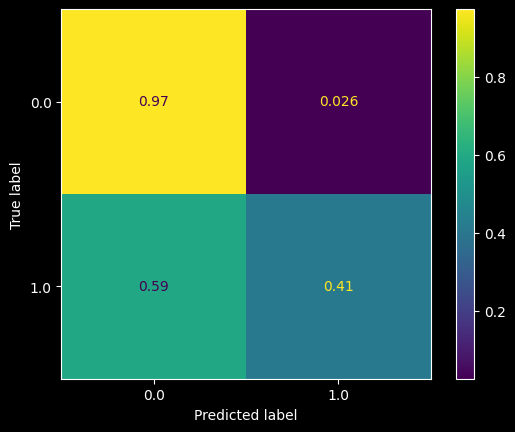

In [34]:
ConfusionMatrixDisplay.from_estimator(model_dummy, X_Val_dummy, y_Val_dummy, normalize='true')

0.97	0.026 <br>
0.59	0.41

Cette matrice montre que notre modèle reconnaît mieux les vrais négatifs (l'individu n'a pas de compte bancaire) par rapport aux vrais positifs (l'individu a un compte bancaire). Cela était prévisible car il y a 6 fois plus de négatifs que de positifs dans le dataset.

### 3.4. Compréhension du modèle

<BarContainer object of 40 artists>

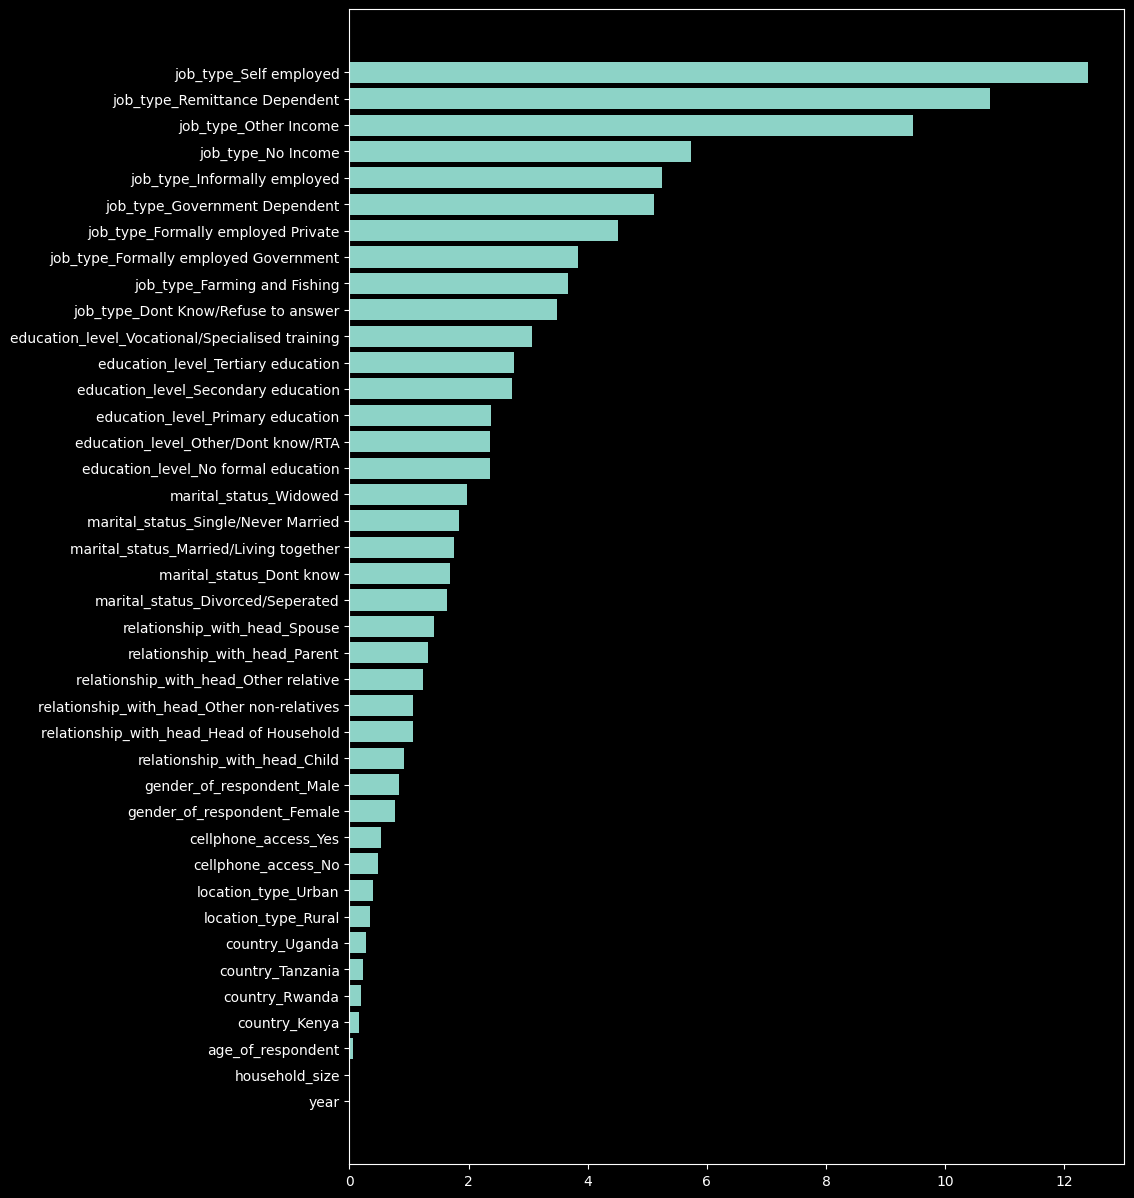

In [35]:
plt.figure(figsize=(10,15))
plt.barh(X_Val_dummy.columns.to_list(), pd.Series(model_dummy.feature_importances_).sort_values())

## 4. Prédiction

Après avoir choisi un modèle, réalisons maintenant les prédictions sur notre ensemble de test.

In [36]:
try:
	test_dummy.drop(TARGET, axis=1, inplace=True)
	# test_featured.drop(TARGET, axis=1, inplace=True)
except:
	pass

In [37]:
test_set[TARGET] = model_dummy.predict(test_dummy)
test_set.head(5)

,country,year,uniqueid,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type,bank_account
0,Kenya,2018,uniqueid_6056,Urban,Yes,3,30,Male,Head of Household,Married/Living together,Secondary education,Formally employed Government,1.0
1,Kenya,2018,uniqueid_6060,Urban,Yes,7,51,Male,Head of Household,Married/Living together,Vocational/Specialised training,Formally employed Private,1.0
2,Kenya,2018,uniqueid_6065,Rural,No,3,77,Female,Parent,Married/Living together,No formal education,Remittance Dependent,0.0
3,Kenya,2018,uniqueid_6072,Rural,No,6,39,Female,Head of Household,Married/Living together,Primary education,Remittance Dependent,0.0
4,Kenya,2018,uniqueid_6073,Urban,No,3,16,Male,Child,Single/Never Married,Secondary education,Remittance Dependent,0.0


## 5. Soumission

Visualisation du fichier d'exemple de soumission

In [30]:
sample_submission.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


In [ ]:
# Faire des prédictions sur l'ensemble de données pour le test
test_df = test_pp.drop([ID], axis = 1)
predictions = clf.predict(test_df)

# Génerer un dataframe pour la soumission
sub_file = pd.DataFrame({'ID': test[ID], 'target': predictions.ravel()})

# Create file
today = dt.now().strftime(format="%Y-%m-%d_%Hh%M")
sub_file.to_csv(f'sub/submission_{today}.csv', index=False)

sub_file.sample(5)

Création de notre fichier de soumission

In [38]:
soumissions = pd.DataFrame(
    {"unique_id": test_set[ID] + " x " + test_set["country"], TARGET: test_set[TARGET].astype(int)})
soumissions.to_csv(
    f'submissions/soumission_{dt.now().strftime(format="%Y-%m-%d_%Hh%M")}.csv', index=False)
soumissions

,unique_id,bank_account
0,uniqueid_6056 x Kenya,1
1,uniqueid_6060 x Kenya,1
2,uniqueid_6065 x Kenya,0
3,uniqueid_6072 x Kenya,0
4,uniqueid_6073 x Kenya,0
...,...,...
10081,uniqueid_2998 x Uganda,0
10082,uniqueid_2999 x Uganda,0
10083,uniqueid_3000 x Uganda,0
10084,uniqueid_3001 x Uganda,0


## 6. Sauvegarde du modèle

In [ ]:
# Save the model as a pickle in a file
# joblib.dump(model_dummy, 'models/catboost_dummy_0.108665476.pkl')

: 